# 03 — Competitive Benchmarking

Cluster hotels into comparable peer groups using K-Means on multi-dimensional rating profiles, then identify under-performers and generate actionable recommendations.

In [4]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

PROJECT_ROOT = Path.cwd()
if (PROJECT_ROOT / "src").exists():
    sys.path.insert(0, str(PROJECT_ROOT))
else:
    PROJECT_ROOT = PROJECT_ROOT.parent
    sys.path.insert(0, str(PROJECT_ROOT))

from src.utils import *
from src.benchmarking import (
    compute_hotel_features,
    cluster_hotels,
    find_optimal_k,
    analyze_group_performance,
    generate_recommendations,
)

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.dpi"] = 120


REPORTS_DIR = PROJECT_ROOT / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

## 3.1 Compute Hotel Features

In [5]:
features = compute_hotel_features(min_reviews=10)
print(f"Hotels with ≥10 reviews: {len(features):,}")
features.describe().round(2)

Hotels with ≥10 reviews: 3,283


,review_count,avg_rating_overall,avg_rating_service,avg_rating_cleanliness,avg_rating_value,avg_rating_location,avg_rating_sleep_quality,avg_rating_rooms,avg_text_length,mobile_ratio
count,3283.00,3283.00,3283.00,3283.00,3283.00,3283.00,3281.00,3283.00,3283.00,3283.00
mean,228.76,3.70,3.89,3.96,3.79,4.09,3.84,3.73,742.80,0.07
std,351.81,0.70,0.64,0.73,0.58,0.58,0.67,0.72,142.84,0.05
min,10.00,1.00,1.20,1.00,1.00,1.25,1.00,1.00,273.00,0.00
25%,36.00,3.37,3.61,3.65,3.54,3.79,3.56,3.38,652.08,0.04
50%,93.00,3.85,4.05,4.17,3.91,4.20,4.00,3.88,743.45,0.06
75%,277.00,4.19,4.34,4.47,4.19,4.53,4.31,4.24,825.90,0.09
max,4153.00,4.92,4.93,5.00,4.93,5.00,5.00,5.00,1671.83,0.50


## 3.2 Find Optimal Number of Clusters

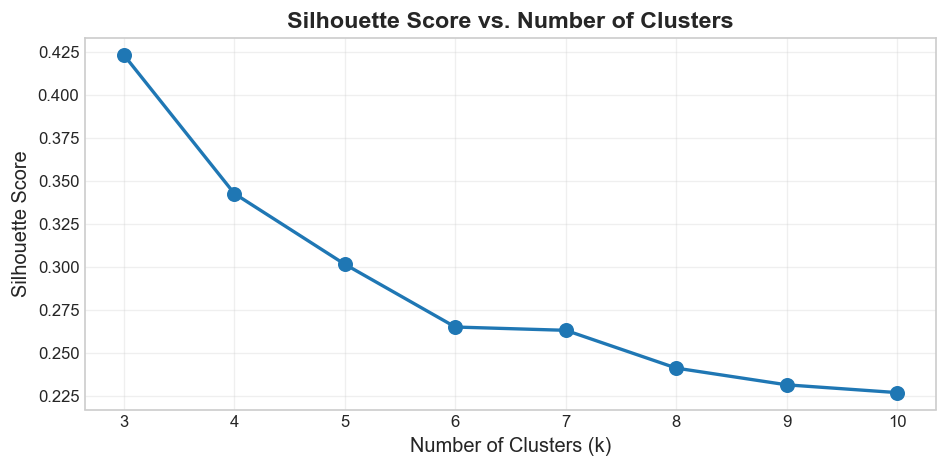

Best k = 3 (silhouette = 0.4232)


In [6]:
scores = find_optimal_k(features, k_range=range(3, 11))

plt.figure(figsize=(8, 4))
plt.plot(list(scores.keys()), list(scores.values()), "o-", linewidth=2, markersize=8)
plt.xlabel("Number of Clusters (k)", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Score vs. Number of Clusters", fontsize=14, fontweight="bold")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "silhouette_scores.png"), bbox_inches="tight")
plt.show()

best_k = max(scores, key=scores.get)
print(f"Best k = {best_k} (silhouette = {scores[best_k]:.4f})")

## 3.3 Perform Clustering

In [7]:
df_clustered, sil_score, km_model, scaler = cluster_hotels(features, n_clusters=best_k)
print(f"Silhouette score: {sil_score:.4f}")
print("Cluster sizes:")
print(df_clustered["cluster"].value_counts().sort_index())

Silhouette score: 0.4232
Cluster sizes:
cluster
0    1821
1    1112
2     348
Name: count, dtype: int64


## 3.4 Cluster Profile — Radar Chart

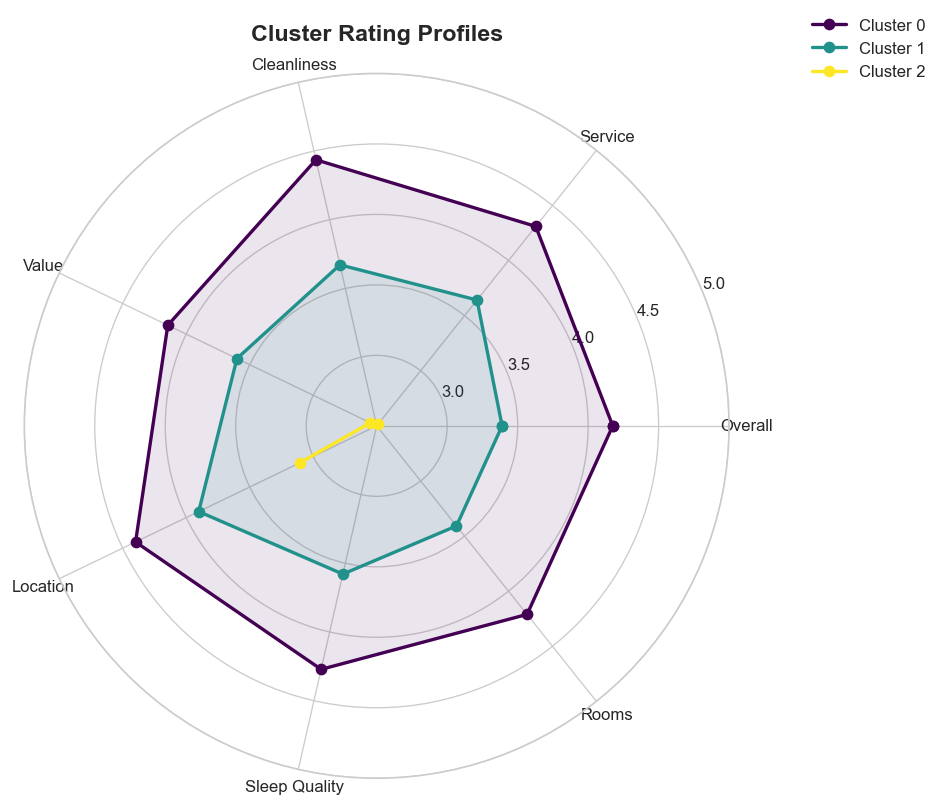

In [8]:
import matplotlib.pyplot as plt
import numpy as np

rating_cols = [c for c in df_clustered.columns if c.startswith("avg_rating_")]
cluster_means = df_clustered.groupby("cluster")[rating_cols].mean()
labels_short = [c.replace("avg_rating_", "").replace("_", " ").title() for c in rating_cols]

angles = np.linspace(0, 2 * np.pi, len(rating_cols), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_means)))
for idx, (cluster_id, row) in enumerate(cluster_means.iterrows()):
    values = row.tolist() + [row.iloc[0]]
    ax.plot(angles, values, "o-", linewidth=2, label=f"Cluster {cluster_id}", color=colors[idx])
    ax.fill(angles, values, alpha=0.1, color=colors[idx])
ax.set_thetagrids(np.degrees(angles[:-1]), labels_short, fontsize=10)
ax.set_ylim(2.5, 5)
ax.set_title("Cluster Rating Profiles", fontsize=14, fontweight="bold", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "cluster_radar.png"), bbox_inches="tight")
plt.show()

## 3.5 Group Performance Summary

In [9]:
summary = analyze_group_performance(df_clustered)
summary

,num_hotels,avg_reviews,avg_rating_overall,avg_rating_service,avg_rating_cleanliness,avg_rating_value,avg_rating_location,avg_rating_sleep_quality,avg_rating_rooms
cluster,,,,,,,,,
0,1821,294.37,4.17,4.31,4.44,4.14,4.40,4.27,4.21
1,1112,174.22,3.39,3.64,3.67,3.60,3.90,3.58,3.41
2,348,60.91,2.21,2.51,2.37,2.55,3.11,2.42,2.23


## 3.6 Scatter: Overall vs Service by Cluster

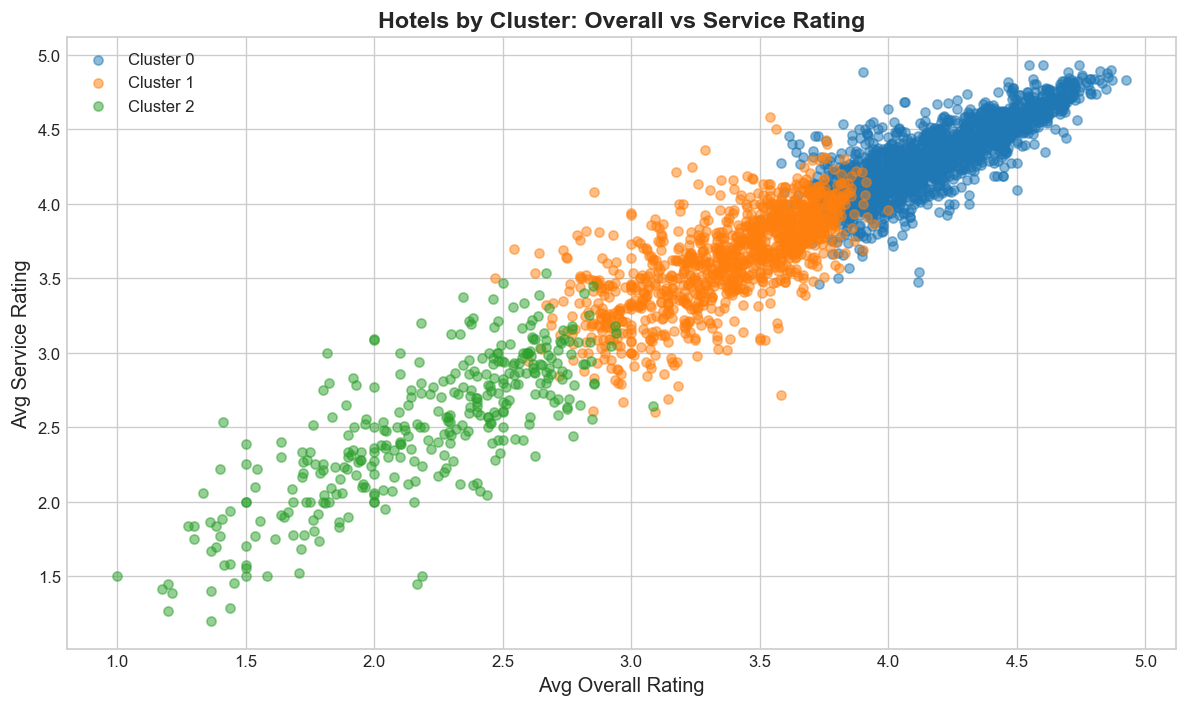

In [10]:
plt.figure(figsize=(10, 6))
for cid in sorted(df_clustered["cluster"].unique()):
    subset = df_clustered[df_clustered["cluster"] == cid]
    plt.scatter(subset["avg_rating_overall"], subset["avg_rating_service"],
                alpha=0.5, label=f"Cluster {cid}", s=30)
plt.xlabel("Avg Overall Rating", fontsize=12)
plt.ylabel("Avg Service Rating", fontsize=12)
plt.title("Hotels by Cluster: Overall vs Service Rating", fontsize=14, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.savefig(str(REPORTS_DIR / "cluster_scatter.png"), bbox_inches="tight")
plt.show()

## 3.7 Recommendations for Under-Performers

In [11]:
recs = generate_recommendations(df_clustered, top_n=20)
print(f"Hotels with improvement opportunities: {len(recs)}")
recs.head(20)

Hotels with improvement opportunities: 1578


,hotel_id,cluster,overall_rating,biggest_weakness,gap_vs_peers,num_weak_dimensions,recommendation
1398,73985,2,1.000000,Location,1.86,7,Focus on improving Location (gap of 1.86 vs pe...
1490,120157,2,1.200000,Location,1.75,7,Focus on improving Location (gap of 1.75 vs pe...
1252,226148,1,3.058824,Location,1.63,3,Focus on improving Location (gap of 1.63 vs pe...
929,84286,1,3.071429,Location,1.62,5,Focus on improving Location (gap of 1.62 vs pe...
1498,123216,2,1.300000,Location,1.61,7,Focus on improving Location (gap of 1.61 vs pe...
1526,240185,2,1.200000,Value,1.55,6,Focus on improving Value (gap of 1.55 vs peer ...
1542,530320,2,1.363636,Value,1.55,7,Focus on improving Value (gap of 1.55 vs peer ...
1015,98664,1,2.928571,Location,1.48,4,Focus on improving Location (gap of 1.48 vs pe...
1447,98934,2,1.411765,Sleep Quality,1.42,6,Focus on improving Sleep Quality (gap of 1.42 ...
1565,1014760,2,2.937500,Sleep Quality,1.42,1,Focus on improving Sleep Quality (gap of 1.42 ...


## 3.8 Validation

We validate the clustering approach via the silhouette score (reported above). A score above 0.25 generally indicates reasonable cluster structure.

In [12]:
print(f"Final silhouette score: {sil_score:.4f}")
if sil_score > 0.25:
    print("→ Clustering has reasonable structure — peer groups are meaningful.")
else:
    print("→ Consider adjusting features or k for better separation.")
print("Benchmarking complete ✓")

Final silhouette score: 0.4232
→ Clustering has reasonable structure — peer groups are meaningful.
Benchmarking complete ✓
